In [ ]:
import os, yaml, sys
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline

ENV = os.getenv("MY_ENV", "dev")
with open("../../config.yaml", "r") as f:
    config = yaml.safe_load(f)
paths = config[ENV]["paths"]
sys.path.append(paths["src_path"])
from general_utils.utils import binary_classification_over_time
from neural_utils.utils import face_fixations
from sklearn.linear_model import LogisticRegression



In [23]:
def plot_accuracy_response(title, st_idx, end_idx, acc_list, tot_face_fix, tot_non_face_fix,  n_timepts_bef, n_timepts_aft, resolution_Hz):
    time_axis = np.arange(-n_timepts_bef, n_timepts_aft) * (1000 / resolution_Hz)
    fig, ax1 = plt.subplots(figsize=(8, 4))

    # ---- Left y-axis (accuracy)
    ax1.plot(time_axis, acc_list, marker=".", color="blue", label="Classification accuracy", linewidth=2)
    ax1.axvline(x=0, color='r', linestyle='--', linewidth=1)
    ax1.axhline(y=0.5, color='r', linestyle='-', linewidth=2, label="Chance")
    ax1.set_xlabel("Time from fixation onset (ms)")
    ax1.set_ylabel("Accuracy", color="blue")
    ax1.tick_params(axis='y', labelcolor="blue")
    # ---- Right y-axis (neural magnitude difference)
    ax2 = ax1.twinx()
    diff_signal = np.mean((np.mean(tot_face_fix[st_idx:end_idx, :, :], axis=2) - np.mean(tot_non_face_fix[st_idx:end_idx, :, :], axis=2)).T,axis=1)
    ax2.plot(time_axis, diff_signal, color="purple", label="Response diff (mean)", linewidth=4)
    ax2.tick_params(axis='y', colors='purple')    # tick marks
    ax2.set_ylabel("Response difference", color="purple")
    ax2.tick_params(axis='y', labelcolor="purple")
    ax2.yaxis.label.set_color('purple')   
    ax2.set_ylim([-0.005, 0.025])
    # ---- Legend handling
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.set_ylim([.45, .70])
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper right")
    ax2.spines['left'].set_color('blue') 
    ax2.spines['right'].set_color('purple')        # left axis line

    plt.title(f"Channels {st_idx} to {end_idx} - {title}")
    plt.tight_layout()
    plt.show()

In [85]:
monkey_name = "venus"
npx = True
imec_n = 0
resolution_Hz = 100
foreperiod_len_timepts = 30
n_timepts_bef, n_timepts_aft = 40, 40
model_name = "human_face_detection"
days = range(19, 25)
month = "sep"
tot_face_fix, tot_occluded_face_fix, tot_non_face_fix, tot_rep_face_fix = face_fixations(paths, monkey_name, days, month, npx, imec_n, resolution_Hz, n_timepts_bef, n_timepts_aft, foreperiod_len_timepts, model_name, normalization="min_max")

18:58:19 - computed day 19 of monkey venus
18:58:19 - computed day 20 of monkey venus
18:58:19 - computed day 21 of monkey venus
18:58:19 - computed day 22 of monkey venus
18:58:19 - computed day 23 of monkey venus
18:58:19 - computed day 24 of monkey venus


In [86]:
print(tot_face_fix.shape[2], tot_occluded_face_fix.shape[2], tot_non_face_fix.shape[2], tot_rep_face_fix.shape[2])

177 36 3773 277


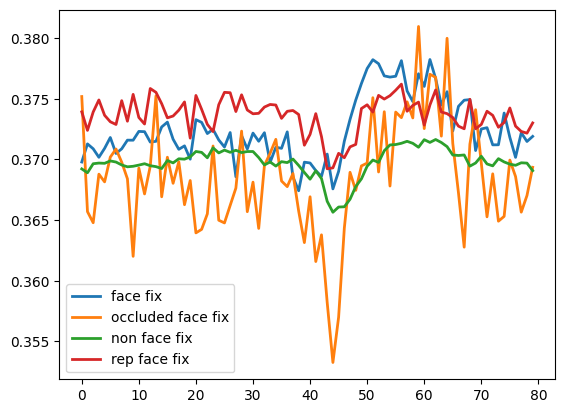

In [87]:
st_idx = 100
end_idx = 150 
plt.plot(np.mean(np.mean(tot_face_fix[st_idx:end_idx, :,:], axis=2), axis=0), linewidth=2) 
plt.plot(np.mean(np.mean(tot_occluded_face_fix[st_idx:end_idx, :,:], axis=2), axis=0), linewidth=2) 
plt.plot(np.mean(np.mean(tot_non_face_fix[st_idx:end_idx, :,:], axis=2), axis=0), linewidth=2) 
plt.plot(np.mean(np.mean(tot_rep_face_fix[st_idx:end_idx, :,:], axis=2), axis=0), linewidth=2) 
plt.legend(["face fix", "occluded face fix", "non face fix", "rep face fix"])

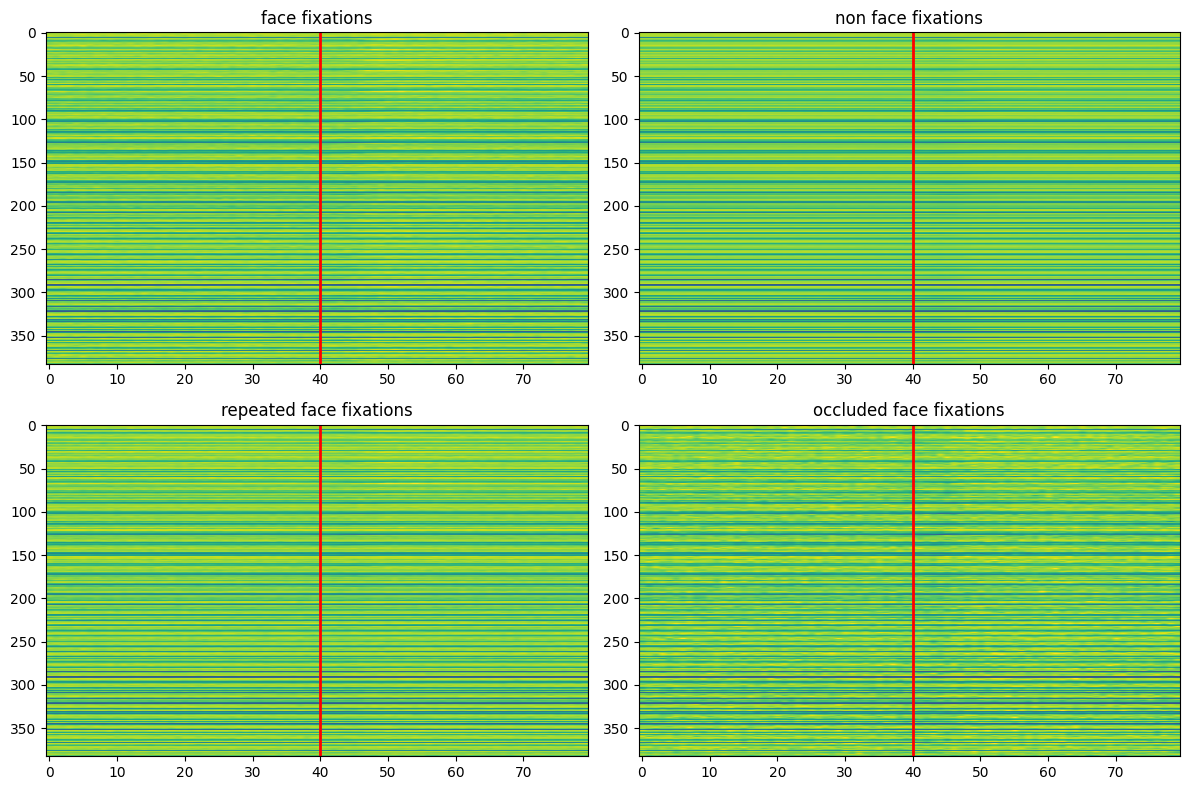

In [88]:
# plots the average data
tot_all_responses = [tot_face_fix, tot_non_face_fix, tot_rep_face_fix, tot_occluded_face_fix]
all_responses_labels = ["face fixations", "non face fixations", "repeated face fixations", "occluded face fixations"]
n_plots = len(tot_all_responses)
n_cols = 2#int(np.ceil(np.sqrt(n_plots)))
n_rows = 2#int(np.ceil(n_plots / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 8))
axes_flat = axes.ravel()
for i in range(n_plots):
    if tot_all_responses[i].shape[1] != 0:
        img = np.mean(tot_all_responses[i], axis=2)
        axes_flat[i].imshow(img, aspect='auto')
        mid_col = img.shape[1] / 2
        axes_flat[i].images[-1].set_clim(0, 0.5)
        axes_flat[i].axvline(mid_col, color='r', linestyle='-', linewidth=2)
        axes_flat[i].set_title(all_responses_labels[i])
plt.tight_layout()  # automatically adjusts spacing
plt.show()

In [73]:
acc_list_f_non_f = binary_classification_over_time(tot_face_fix, tot_non_face_fix, [st_idx, end_idx], 10, LogisticRegression, **{"max_iter": 1000})
acc_list_rep = binary_classification_over_time(tot_rep_face_fix, tot_non_face_fix, [st_idx, end_idx], 10, LogisticRegression, **{"max_iter": 1000})
acc_list_rep_vs_non_rep = binary_classification_over_time(tot_rep_face_fix, tot_face_fix, [st_idx, end_idx], 10, LogisticRegression, **{"max_iter": 1000})
acc_list_occl_f_non_f = binary_classification_over_time(tot_occluded_face_fix, tot_non_face_fix, [st_idx, end_idx], 10, LogisticRegression, **{"max_iter": 1000})

other two possibilities

In [74]:
# from sklearn.svm import LinearSVC
# from sklearn.svm import SVC
# #acc_list_f_non_f = binary_classification_over_time(tot_face_fix, tot_non_face_fix, [0,50], 10, LinearSVC, **{"max_iter": 1000})
# #acc_list_f_non_f = binary_classification_over_time(tot_face_fix, tot_non_face_fix, [0,50], 10, SVC, **{"max_iter": 1000, 'kernel': 'rbf'})

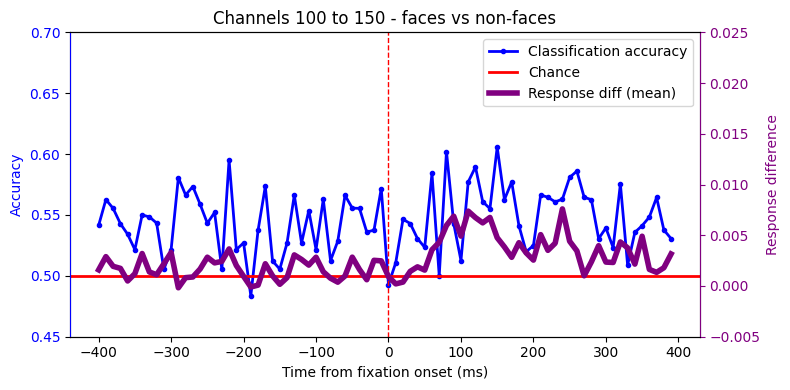

In [75]:
plot_accuracy_response("faces vs non-faces", st_idx, end_idx, acc_list_f_non_f, tot_face_fix, tot_non_face_fix,  n_timepts_bef, n_timepts_aft, resolution_Hz)

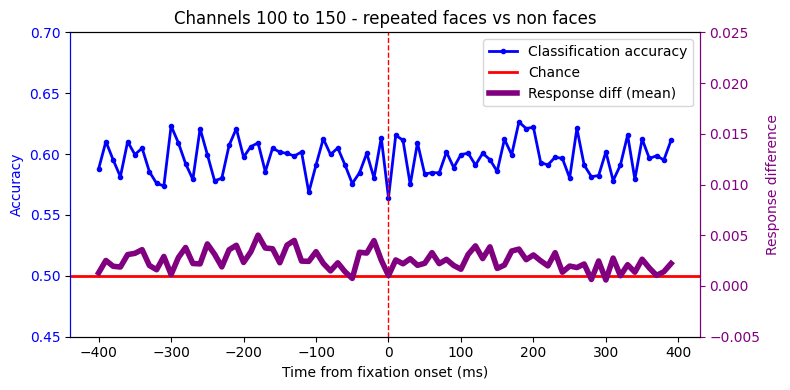

In [76]:
plot_accuracy_response("repeated faces vs non faces", st_idx, end_idx, acc_list_rep, tot_rep_face_fix, tot_non_face_fix,  n_timepts_bef, n_timepts_aft, resolution_Hz)

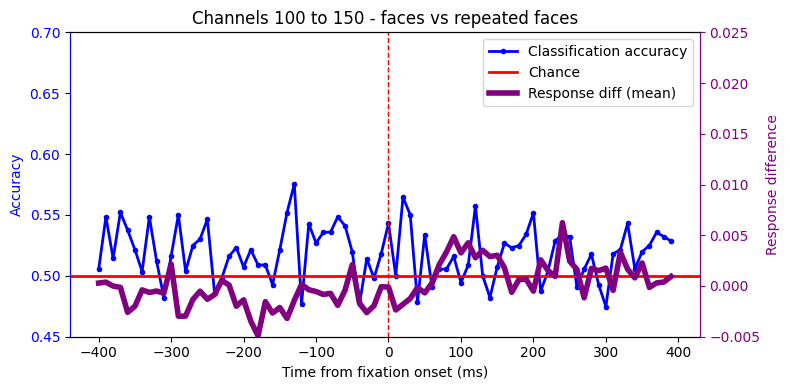

In [77]:
plot_accuracy_response("faces vs repeated faces", st_idx, end_idx, acc_list_rep_vs_non_rep, tot_face_fix, tot_rep_face_fix,  n_timepts_bef, n_timepts_aft, resolution_Hz)

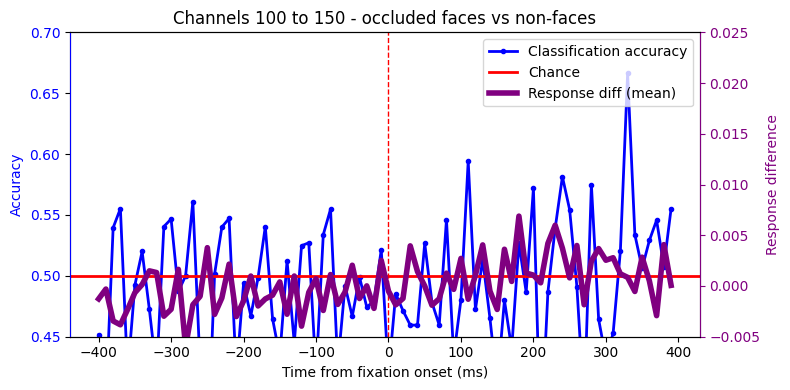

In [78]:
plot_accuracy_response("occluded faces vs non-faces", st_idx, end_idx, acc_list_occl_f_non_f, tot_occluded_face_fix,tot_non_face_fix,  n_timepts_bef, n_timepts_aft, resolution_Hz)

In [21]:
from sklearn.decomposition import PCA
pca_non_faces = PCA(n_components=2)  # reduce to 2 components
pca_non_faces.fit(np.reshape(tot_non_face_fix, (tot_non_face_fix.shape[0], -1)).T)
pca_faces = PCA(n_components=2)  # reduce to 2 components
pca_faces.fit(np.reshape(tot_face_fix, (tot_face_fix.shape[0], -1)).T)

,n_components,2
,copy,True
,whiten,False
,svd_solver,'auto'
,tol,0.0
,iterated_power,'auto'
,n_oversamples,10
,power_iteration_normalizer,'auto'
,random_state,None


In [22]:
evecs_non_face = pca_non_faces.components_
evecs_face = pca_faces.components_


In [35]:
all_activations = np.concatenate((tot_non_face_fix, tot_face_fix), axis=2)

In [39]:
pca_all = PCA(n_components=2)  # reduce to 2 components
pca_all.fit(np.reshape(all_activations, (all_activations.shape[0], -1)).T)
evecs_all = pca_all.components_

In [52]:
pca_non_faces = PCA(n_components=2)  # reduce to 2 components
pca_non_faces.fit(np.reshape(tot_non_face_fix, (tot_non_face_fix.shape[0], -1)).T)

,n_components,2
,copy,True
,whiten,False
,svd_solver,'auto'
,tol,0.0
,iterated_power,'auto'
,n_oversamples,10
,power_iteration_normalizer,'auto'
,random_state,None


In [53]:
tpts_non_faces = []
tpts_faces = []
for i in range(tot_non_face_fix.shape[1]):
    # tpts_non_faces.append(np.mean(evecs_non_face @ tot_non_face_fix[:,i,:], axis=1))
    # tpts_faces.append(np.mean(evecs_face @ tot_face_fix[:,i,:], axis=1))
    tpts_non_faces.append(np.mean(evecs_all @ tot_non_face_fix[:,i,:], axis=1))
    tpts_faces.append(np.mean(evecs_all @ tot_face_fix[:,i,:], axis=1))

all_non_faces = np.stack(tpts_non_faces, axis=1)
all_faces = np.stack(tpts_faces, axis=1)


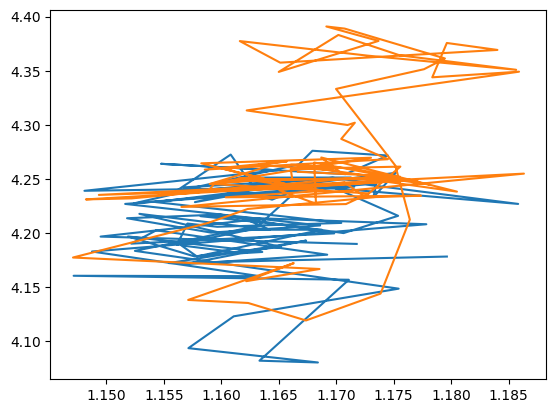

In [54]:
from IPython.display import clear_output
for i in range(all_faces.shape[1]):
    plt.plot(all_non_faces[0,:i], all_non_faces[1,:i])
    plt.plot(all_faces[0,:i], all_faces[1,:i])
    plt.pause(.1)
    clear_output(wait=True)